# 視覺化進出場策略 (Visualizing Strategies)

## 看一下單一股票的進出場狀況

In [1]:
import os
import sys

In [2]:
# 把我們自己寫的模組的位置，加入到模組搜尋路徑之中，不然會有 import error
module_dir = os.path.join(os.path.dirname(os.getcwd()), 'modules')
if not module_dir in sys.path:
    sys.path.append(module_dir)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import crawler
import backtest

## 讀取歷史股價

In [4]:
start = datetime(2017,1,1)
end = datetime(2017,12,31)

In [5]:
# 讀取從指定日期之後的股價資訊
df = crawler.get_quotes("AMZN", start, end)

## 訂定策略

進出點的計算，可以參考：

https://www.quantstart.com/articles/Backtesting-a-Moving-Average-Crossover-in-Python-with-pandas

In [6]:
# 突破策略
def breakout(df):
    # Donchian Channel
    df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
    df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['Close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

In [7]:
# 突破策略
def macross(df):
    # 均線
    df['20d'] = pd.Series.rolling(df['Close'], window=20).mean()
    df['5d'] = pd.Series.rolling(df['Close'], window=5).mean()

    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['5d'][t] > df['20d'][t] and df['5d'][t-1] < df['20d'][t-1] and df['20d'][t] > df['20d'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] < df['20d'][t] and df['Close'][t-1] < df['20d'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

In [8]:
def apply_strategy(strategy, df):
    return strategy(df)

In [9]:
apply_strategy(macross, df)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A1211ADAC8>,
      dtype=object)

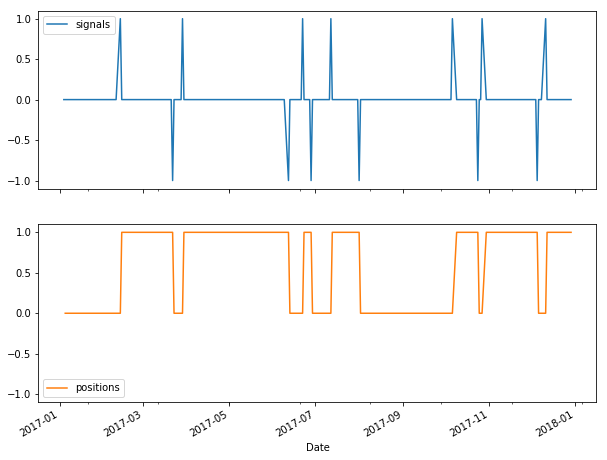

In [10]:
# 底下這一行只是為了要在下面把 signals 跟 positions 畫出來做說明用
df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (10, 8))

## 標出進出場點

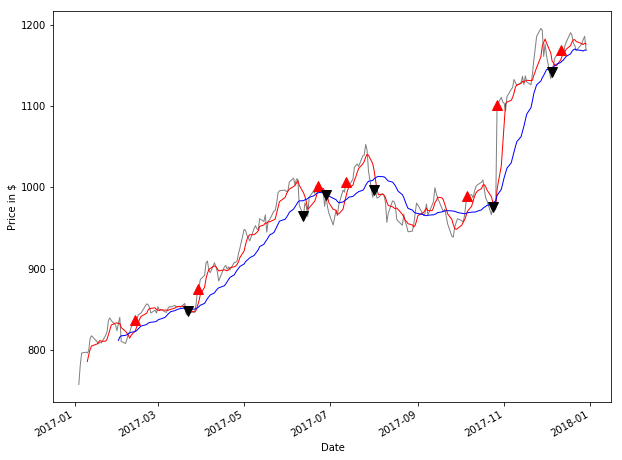

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
df['Close'].plot(ax=ax1, color='gray', lw=1., figsize=(10,8))
df['5d'].plot(ax=ax1, color='r', lw=1.)
df['20d'].plot(ax=ax1, color='b', lw=1.)

# Plot the "buy" trades
ax1.plot(df.loc[df.signals == 1].index,df['Close'][df.signals == 1],'^', markersize=10, color='r')

# Plot the "sell" trades
ax1.plot(df.loc[df.signals == -1].index, df['Close'][df.signals == -1], 'v', markersize=10, color='k')

## 計算Sharpe Ratio

In [12]:
dailyRet = df['Close'].pct_change()

In [13]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = (dailyRet - 0.04/252)[df['positions']==1]

sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)

In [14]:
sharpeRatio

1.072342302480084

## 計算MaxDD跟MaxDDD

In [15]:
df['Ret'] = np.where(df['positions']==1, dailyRet, 0)
cumRet = np.cumprod(1 + df['Ret'])

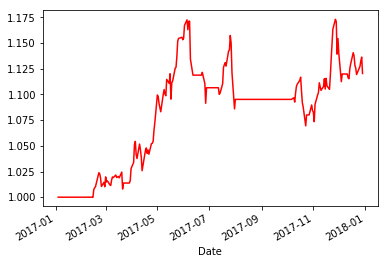

In [16]:
cumRet.plot(style='r-')

In [17]:
backtest.DrawDownAnalysis(cumRet)

(-0.08800917655794649, 174)